In [150]:
import pandas as pd
import pandasql as ps #This package allows us to query a pandas dataframe using SQL
from matplotlib import pyplot as plt   
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
df_covid = pd.read_csv("https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11/download/covidtesting.csv")

#We now rename all the columns (to be used in this project) to avoid spaces in the column names to simplify the work when we wish to query our dataframe.

df_covid.rename(columns = {"Reported Date" : "Reported_Date", "Presumptive Positive" : "Presumptive_Positive", "Confirmed Positive" : "Confirmed_Positive", "Number of patients hospitalized with COVID-19" : "Number_of_patients_hospitalized_with_COVID19", "Total LTC Resident Deaths" : "Total_LTC_Resident_Deaths", "Total LTC HCW Deaths" : "Total_LTC_HCW_Deaths"}, inplace = True) 


The following cell derives cumulative positive cases and cumulative hospitalizations due to covid-19. We also plot these on the same plot.

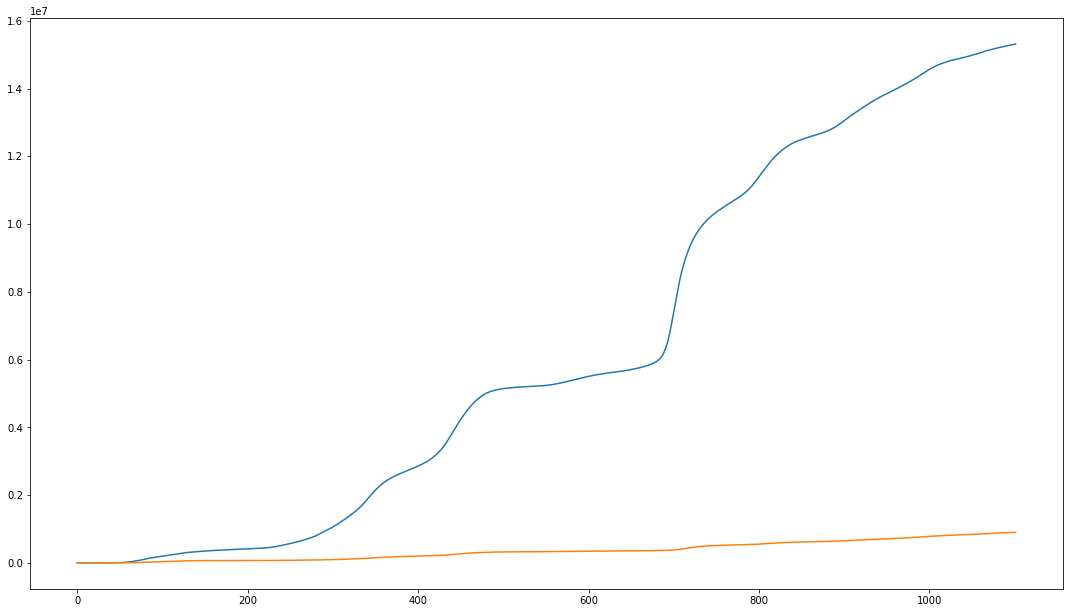

In [151]:
df_covid['Confirmed_Positive'] = df_covid['Confirmed_Positive'].fillna(0) #We remove the "NaN" entries and replace them with 0.
df_covid['Number_of_patients_hospitalized_with_COVID19'] = df_covid['Number_of_patients_hospitalized_with_COVID19'].fillna(0)


query1 = "select sum(Confirmed_Positive) over (order by Reported_Date) as cumulative_positive from df_covid "
cumu_frame = ps.sqldf(query1,locals()) #Dataframe where the column containing data represents the cumulative sum of confirmed positive cases.

cumu_cases_list = cumu_frame.cumulative_positive.tolist() #Store the cumuluative positive cases as a list.

query2 = "select sum(Number_of_patients_hospitalized_with_COVID19) over (order by Reported_Date) as cumulative_hospitalized from df_covid"
cumu_hospitalized_frame = ps.sqldf(query2, locals())
hosp_list = cumu_hospitalized_frame.cumulative_hospitalized.tolist()

plt.plot(cumu_cases_list)
plt.plot(hosp_list) #Plots cumulative positive cases and cumulative hospitalizations on the same graph.
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)
plt.savefig('cumulative confirmed cases vs hospitalizations') #Save as an image in working directory.





Now, we perform linear regression and use the result to visualize how (in a linear model/approximation) the evolution of (cumulative) positive cases affects (cumulative) hospitalizations.

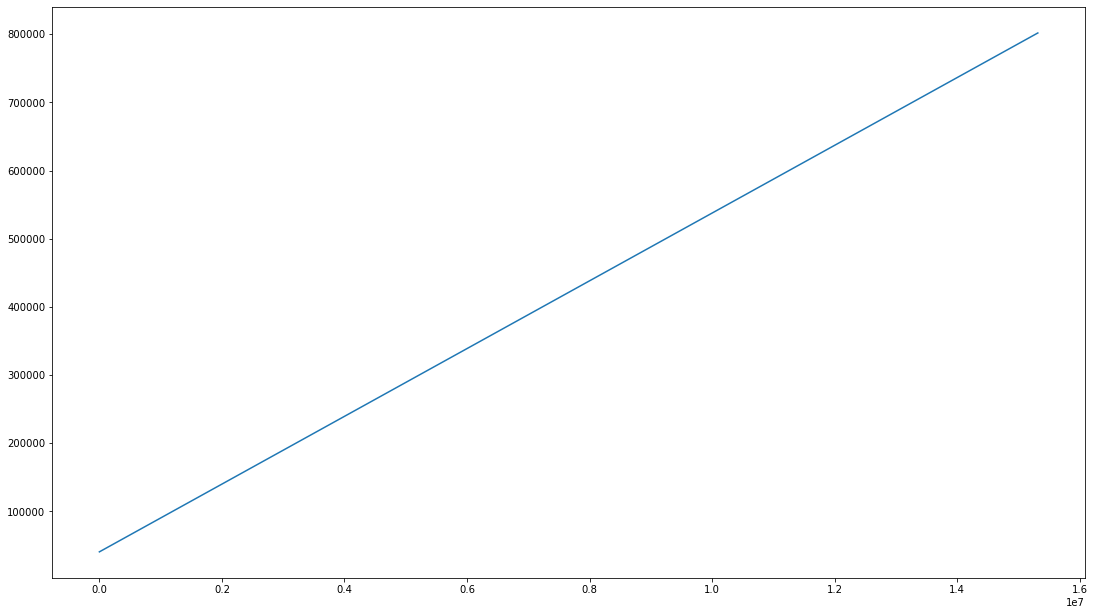

In [152]:
X = cumu_frame['cumulative_positive'].values.reshape(-1,1)
y = cumu_hospitalized_frame['cumulative_hospitalized'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)


#The regression coefficient is regressor.coef_, which is ~0.04. Thus, indeed, as positive cases increase, so do hospitalizations.

line_list = [i*regressor.coef_[0] + regressor.intercept_[0] for i in cumu_cases_list]

plt.plot(cumu_cases_list,line_list)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)
plt.savefig('linearregressionplot')

We repeat the above analysis but using confirmed positive and presumed positive, to see how this affects the outcome.

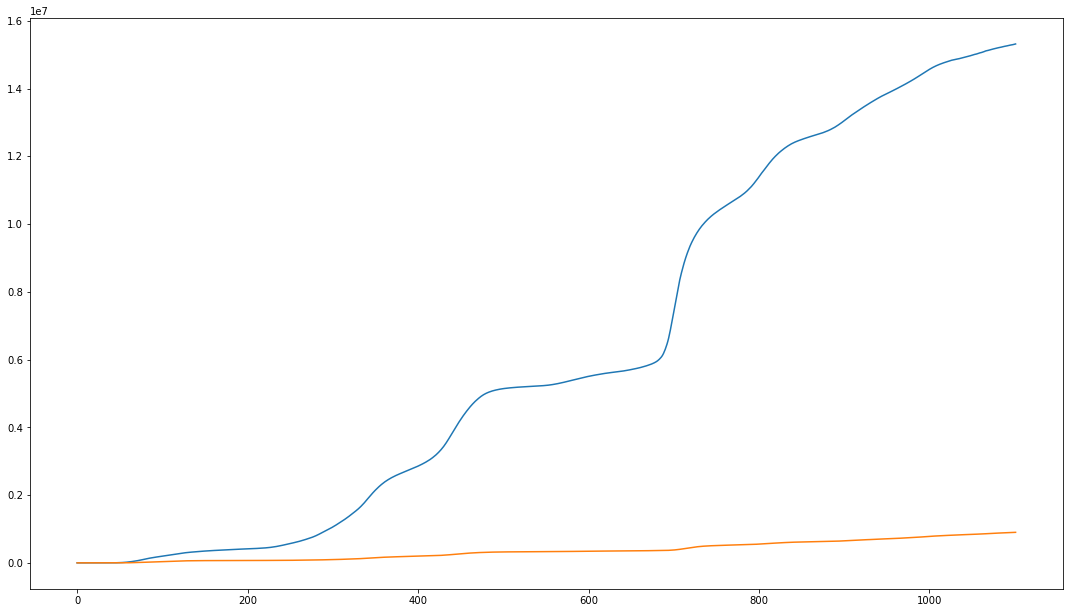

In [153]:
df_covid['Presumptive_Positive'] = df_covid['Presumptive_Positive'].fillna(0) #Replace NaN with 0 to be able to compute quantities involving them.
query3 = "select sum(Confirmed_Positive + Presumptive_Positive) over (order by Reported_Date) as cumulative_positive_total from df_covid "
cumu_total_frame = ps.sqldf(query3,locals())
cumu_total_list = cumu_total_frame.cumulative_positive_total.tolist()

plt.plot(cumu_total_list)
plt.plot(hosp_list)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)
plt.savefig('total cumulative cases vs hospitalizations')




We next perform a similar analysis to see how cumulative Covid-19 cases affect deaths (the new death methodology continues tallying deaths after the old methodology was phased out).

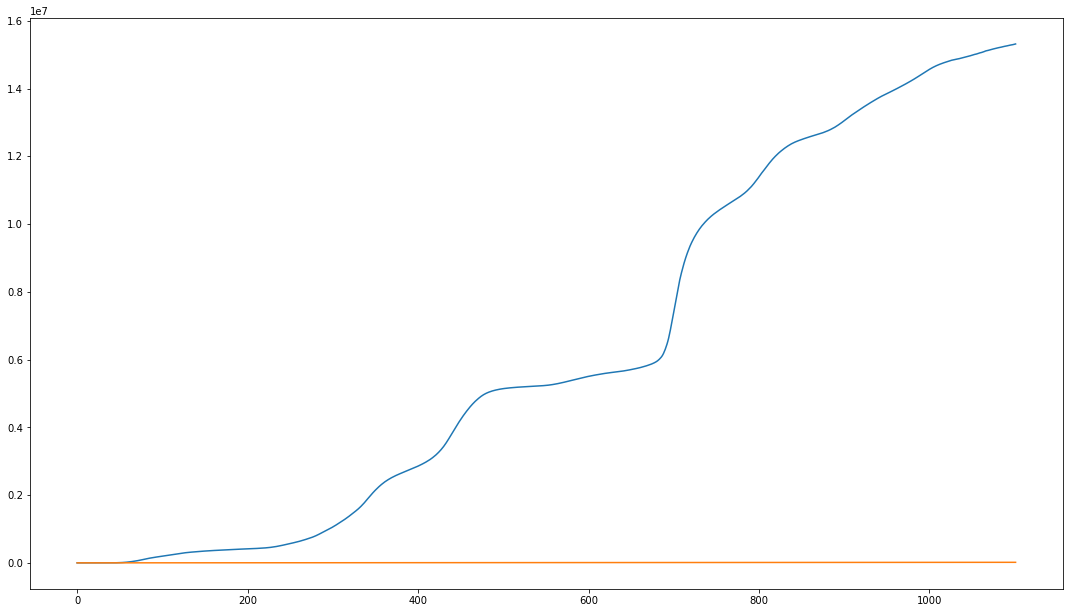

In [154]:
df_covid['Deaths'] = df_covid['Deaths'].fillna(0)
df_covid['Deaths_New_Methodology'] = df_covid['Deaths_New_Methodology'].fillna(0)

death_list = [x+y for x,y in zip(df_covid['Deaths'],df_covid['Deaths_New_Methodology'])]
plt.plot(cumu_cases_list)
plt.plot(death_list)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)
plt.savefig('Cumulative cases vs Deaths')


Next, we perform regression analysis.

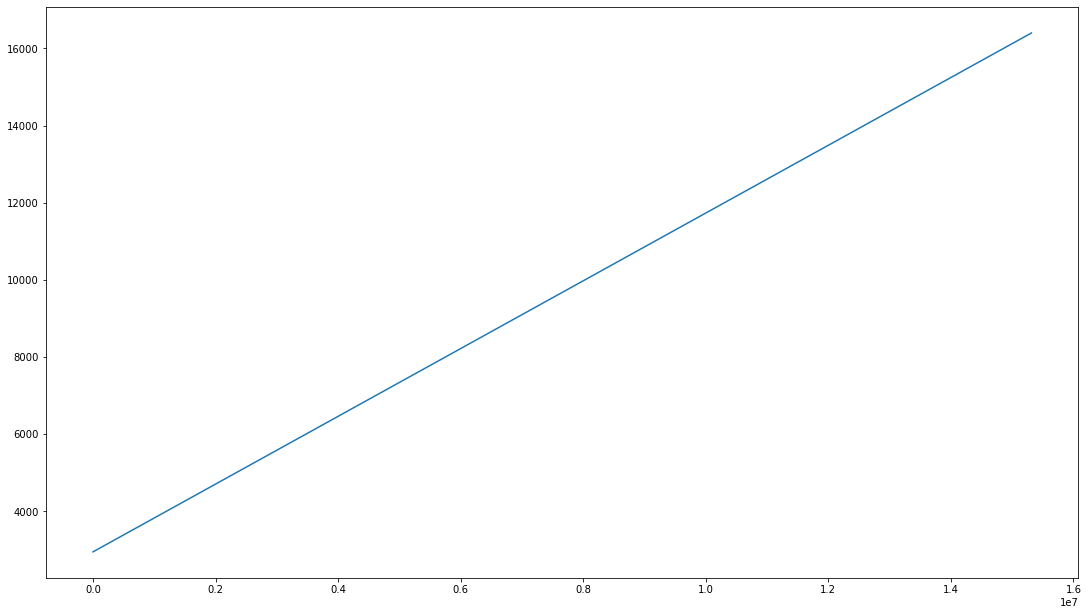

In [160]:
death_frame = cumu_frame
death_frame['Overall_Deaths'] = death_list

X = cumu_frame['cumulative_positive'].values.reshape(-1,1)
y = death_frame['Overall_Deaths'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

death_line = [i*regressor.coef_[0] + regressor.intercept_[0] for i in cumu_cases_list]

plt.plot(cumu_cases_list,death_line)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)
plt.savefig('death_cases_regressionline')


We repeat the above analysis but using confirmed positive and presumed positive, to see how this affects the outcome.

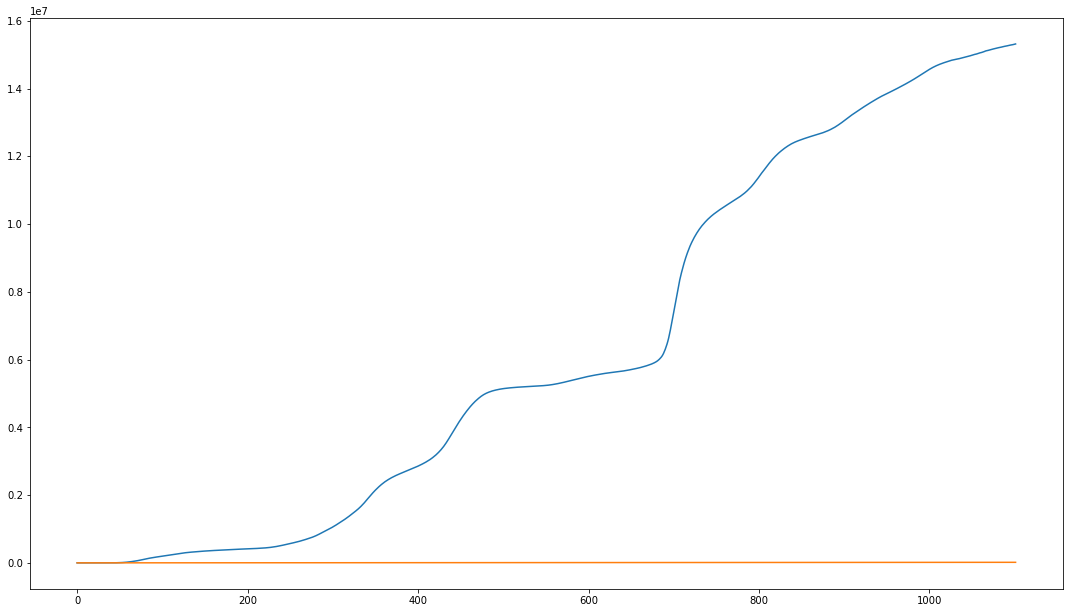

In [156]:
plt.plot(cumu_total_list)
plt.plot(death_list)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)
plt.savefig('Total Cumulative cases vs Deaths')


We now examine how the LTC deaths compare to the total deaths and if they are related. We must examine LTC Resident deaths as well as LTC HCW deaths. Since there are far fewer healthcare workers than residents, we will first use the resident deaths and then the total LTC deaths.

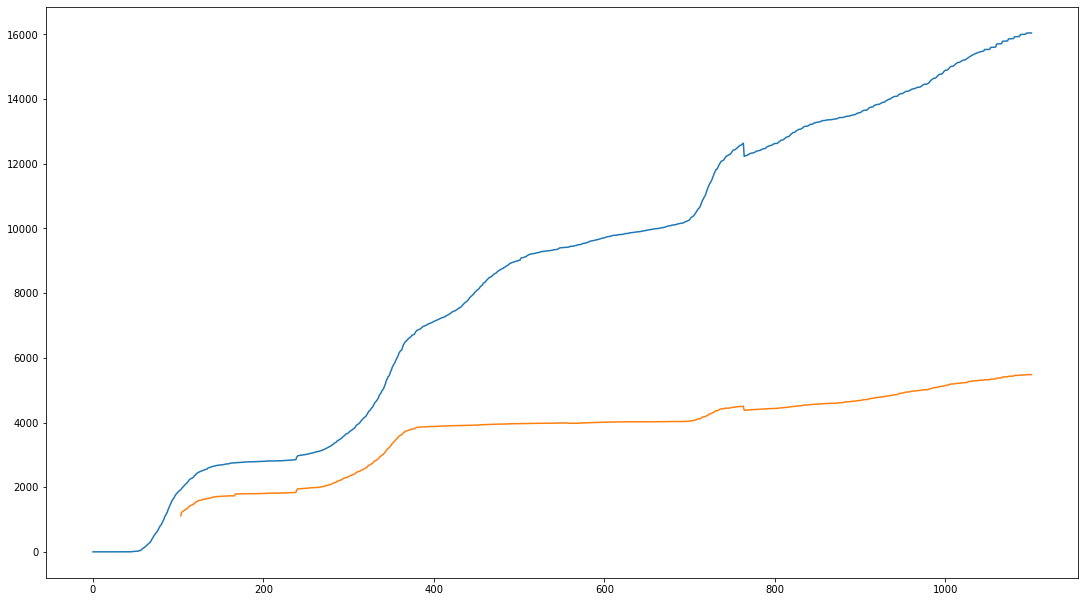

In [164]:
resident_list = df_covid.Total_LTC_Resident_Deaths.tolist()
hcw_list = df_covid.Total_LTC_HCW_Deaths.tolist()


plt.plot(death_list)
plt.plot(resident_list)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)
plt.savefig('Total deaths vs LTC Resident deaths')



Next, we examine how the total LTC deaths compare to the total deaths.

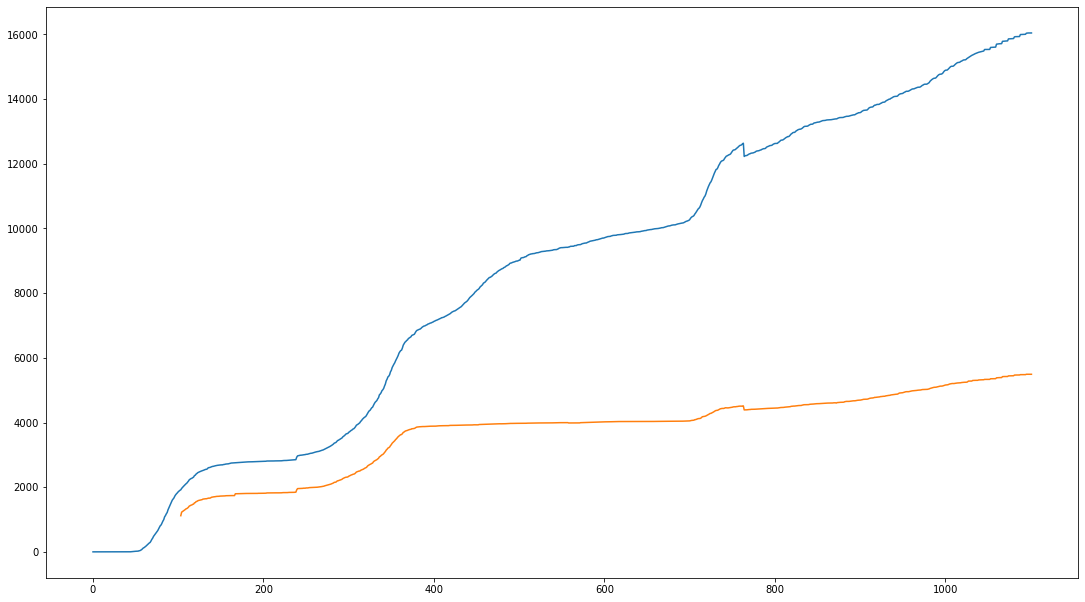

In [166]:
total_ltc_list = [x+y for x, y in zip(resident_list,hcw_list)]
plt.plot(death_list)
plt.plot(total_ltc_list)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)
plt.savefig('Total LTC deaths vs Total Deaths')
